In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

from fastprogress import progress_bar

import jlinops
import sampi

In [99]:
dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

# Toy problem

In [151]:
ground_truth = 1.0*jlinops.piecewise_constant_1d_test_problem() + 1.0
#ground_truth = jlinops.comp_emp_bayes_t1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
L = 10
#A = jlinops.Gaussian1DBlurOperator(n, blur_sigma=20.0, mode="wrap")
A = jlinops.IdentityOperator( (n,n) )
noisy_signal = A.matvec(ground_truth)*np.random.gamma(shape=L, scale=1/L, size=ground_truth.shape)
log_noisy_signal = np.log(noisy_signal)
grid = np.arange(n)

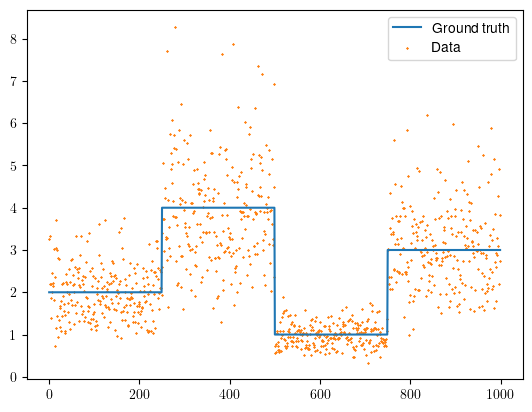

In [70]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# Solvers

In [160]:

class DespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, A, R, f, hyperparams, L=1, pdata={}):

        # Bind
        self.f = f
        self.R = R
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, u0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if u0 is None:
            u = np.ones(self.n)
        else:
            u = u0
        
        # Handle warmstarting
        if warmstarting:
            u_prev = u.copy()
        else:
            u_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(u)

            # Update u
            u, iters, flag = self.x_update(theta_curr, u0=u_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                u_prev = u.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(u, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "u": u,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, u0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Call projected Newton-Krylov solver
            newton_data = sampi.despeckling_newton_krylov(self.A, self.R, theta, self.L, self.f, u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]



        else:

            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)

            #despeckling_priorconditioned_newton_krylov

            newton_data = sampi.despeckling_priorconditioned_newton_krylov(self.f, self.L, self.A, Rtilde, Rpinv, self.pdata["W"], u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]
          

            # # Build current Rpinv operator
            # Rpinv = self.pdata["Rpinv_factory"](theta)

            # newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            # return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, u):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (u) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, u, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        Au = self.A.matvec(u)
        gamma_likelihood = self.L*(np.log( Au ).sum() + (self.f/Au).sum())
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ u)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gamma_likelihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



# Test

In [161]:
# Define forward operator and regularization matrix
R, W = jlinops.first_order_derivative_1d(n, boundary="none")
W = jlinops.MatrixLinearOperator(W)
R = jlinops.MatrixLinearOperator(R)

In [162]:

_Rpinv = jlinops.MatrixLinearOperator(np.linalg.pinv(R.A.toarray()))
Rpinv_factory = lambda theta: _Rpinv @ jlinops.DiagonalOperator(np.sqrt(theta))

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

# hyperparams = {
#     "prior": {
#         "r": 0.5,
#         "beta": 3 + 1e-1,
#         "vartheta": 1e-6,
#     },
# }

hyperparams = {
    "prior": {
        "r": -1,
        "beta": 1,
        "vartheta": 1e-4,
    },
}

# Create solver
solver = DespecklingIASSolver(A, R, noisy_signal, hyperparams, L=L, pdata=pdata)

In [163]:
priorconditioning = False
x_update_solver_params = {
    "newton_maxiter": 25,
    "newton_tol": 1e-3,
    "cg_tol": 1e-3,
    "cg_maxiter": None,
    "backtrack_alpha": 0.4,
    "backtrack_beta": 0.9,
    "search_maxiter": 100,
}

# priorconditioning = True
# x_update_solver_params = {
#     "newton_maxiter": 25,
#     "newton_tol": 1e-3,
#     "tol": 1e-8,
#     "maxiter": None,
#     "backtrack_alpha": 0.4,
#     "backtrack_beta": 0.9,
#     "search_maxiter": 100,
# }

data = solver.solve(max_iters=50, u0=noisy_signal, warmstarting=True, eps=1e-4, early_stopping=True,
                    x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

10
5
5
4
4
4
3
3
3
2
0


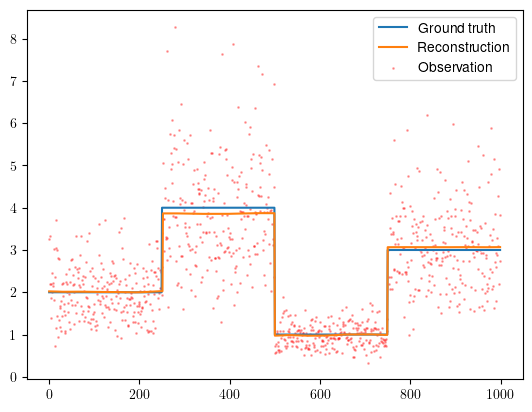

In [164]:
plt.plot(ground_truth, label=r"Ground truth")
plt.plot(data["u"], label="Reconstruction")
#plt.plot(noisy_signal, alpha=0.3)
plt.scatter([i for i in range(len(noisy_signal))], noisy_signal, label="Observation", s=1.0, alpha=0.3, color="red")
#plt.plot(noisy_signal, label="Observation", ls="--", alpha=0.3)
plt.legend()
plt.show()

# Do reconstruction for several values of vartheta

In [165]:
varthetas_data = [(1e-1, "\vartheta = 10^{-1}" ), (1e-2, "\vartheta = 10^{-2}"), (1e-4, "\vartheta = 10^{-4}" ) ]
reconstructions = []
for item in varthetas_data:
    vartheta, _ = item


    hyperparams = {
        "prior": {
            "r": -1,
            "beta": 1,
            "vartheta": vartheta,
        },
    }

    # Create solver
    solver = DespecklingIASSolver(A, R, noisy_signal, hyperparams, L=L, pdata=pdata)

    priorconditioning = False
    x_update_solver_params = {
        "newton_maxiter": 25,
        "newton_tol": 1e-3,
        "cg_tol": 1e-3,
        "cg_maxiter": None,
        "backtrack_alpha": 0.4,
        "backtrack_beta": 0.9,
        "search_maxiter": 100,
    }

    # priorconditioning = True
    # x_update_solver_params = {
    #     "newton_maxiter": 25,
    #     "newton_tol": 1e-3,
    #     "tol": 1e-8,
    #     "maxiter": None,
    #     "backtrack_alpha": 0.4,
    #     "backtrack_beta": 0.9,
    #     "search_maxiter": 100,
    # }

    data = solver.solve(max_iters=50, u0=noisy_signal, warmstarting=True, eps=1e-4, early_stopping=True,
                        x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

    reconstructions.append(data["u"])

12
7
6
5
5
4
3
2
2
2
2
2
2
2
2
2
2
2
2


10
5
5
4
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2


10
5
5
4
4
4
3
3
3
2
0


In [166]:
# plt.plot(ground_truth, label=r"Ground truth")
# plt.scatter([i for i in range(len(noisy_signal))], noisy_signal, label="Observation", s=1.0, alpha=0.3, color="red")

# for j in range(4):
    
#     plt.plot(reconstructions[j])

# plt.legend()
# plt.show()

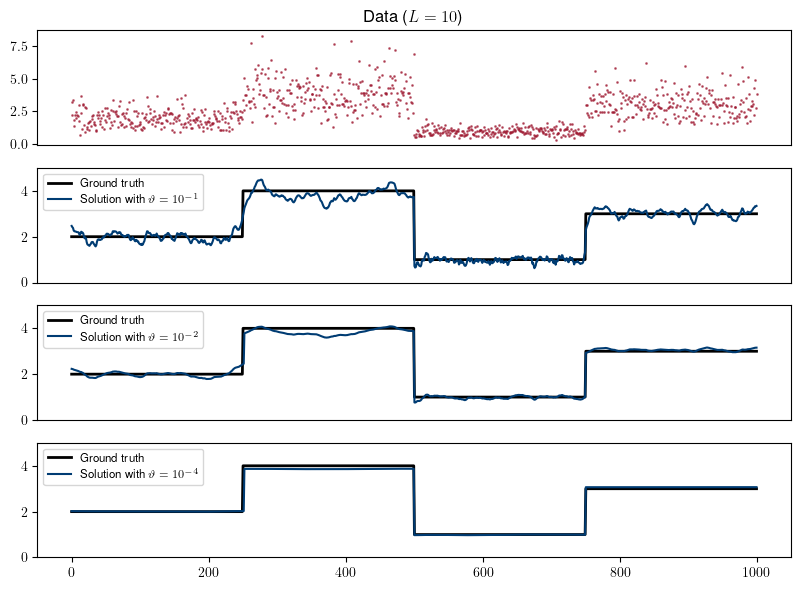

In [167]:
fig, axs = plt.subplots(4,1,figsize=(8,6))

axs[0].scatter([i for i in range(len(noisy_signal))], noisy_signal, label="Observation", s=1.0, alpha=0.6, color=dcolors["bonfire_red"])
axs[0].set_title("Data ($L = 10$)")

labels = [
    "Solution with $\\vartheta = 10^{-1}$",
    "Solution with $\\vartheta = 10^{-2}$", 
    "Solution with $\\vartheta = 10^{-4}$",  
]

for j, ax in enumerate(axs.reshape(-1)):

    if j < 1:
        ax.set_xticks([])
    else:
        ax.plot(ground_truth, label=r"Ground truth", color=dcolors["midnight_black"], lw=2.0)

        if j < 3:
            ax.set_xticks([])

        ax.plot(reconstructions[j-1], color=dcolors["river_navy"], label=labels[j-1])
        ax.set_ylim(0, 5)
        ax.legend(fontsize="small", loc="upper left")
        #ax.set_title(labels[j-1])
    
fig.tight_layout()

fig.savefig("varying_vartheta.png", dpi=250)

plt.show()

# Also try reconstruction using Gaussian IAS

In [168]:
# Prior parameters
hyperparams = {
    "prior": {
        "r": -1,
        "beta": 1,
        "vartheta": 1e-4,
    },
    # "noise_var": {
    #     "r": -1.0,
    #     "beta": 1,
    #     "vartheta": 1e-8,
    # }
}

# Create solver
solver = sampi.IASSolver(A, R, noisy_signal, hyperparams, noise_var=0.3, pdata=pdata)

In [169]:
data = solver.solve(max_iters=100, priorconditioning=True, early_stopping=False, warmstarting=True, eps=1e-3)

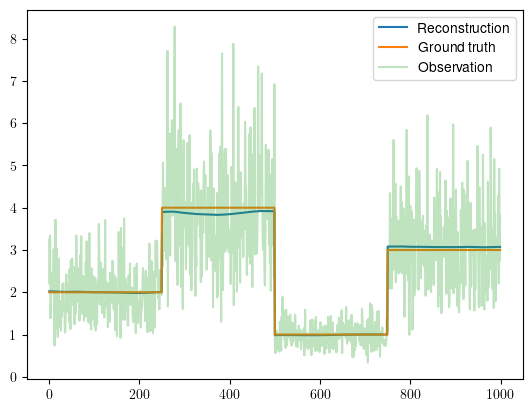

In [170]:
plt.plot(data["x"], label="Reconstruction")
plt.plot(ground_truth, label="Ground truth")
plt.plot(noisy_signal, label="Observation", alpha=0.3)
plt.legend()
plt.show()

# Use log model instead?

In [171]:

class LogDespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, R, y, hyperparams, L=1, pdata={}):

        # Bind
        self.y = y
        self.R = R
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, x0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if x0 is None:
            x = np.ones(self.n)
        else:
            x = x0
        
        # Handle warmstarting
        if warmstarting:
            x_prev = x.copy()
        else:
            x_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(x)

            # Update x
            x, iters, flag = self.x_update(theta_curr, x0=x_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                x_prev = x.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(x, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "x": x,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, x0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Functions for objective, gradient, and hessian
            obj_fn = lambda x: self.L*( np.exp(self.y - x) + x - self.y ).sum() + 0.5*((np.linalg.norm( Rtilde @ x ))**2)
            grad_fn = lambda x: self.L*(1 - np.exp(self.y - x)) + Rtilde.rmatvec(Rtilde.matvec(x))
            inv_hess_fn = lambda x: jlinops.DiagonalOperator( self.L*np.exp(self.y-x) ) + (Rtilde.T @ Rtilde)

            # Call Newton-Krylov solver
            newton_data = sampi.newton_krylov(obj_fn, grad_fn, inv_hess_fn, x0=x0, **kwargs)

            return newton_data["x"], newton_data["n_iters"], newton_data["converged"]
        

        else:

            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)

            newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, x):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (x) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, x, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        ft_likeihood = self.L*( np.exp(self.y - x) + x - self.y ).sum()
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ x)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = ft_likeihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



In [172]:
varthetas_data = [(1e-1, "\vartheta = 10^{-1}" ), (1e-2, "\vartheta = 10^{-2}"), (1e-4, "\vartheta = 10^{-4}" ) ]
log_reconstructions = []
for item in varthetas_data:
    vartheta, _ = item


    hyperparams = {
        "prior": {
            "r": -1,
            "beta": 1,
            "vartheta": vartheta,
        },
    }

    # Create solver
    solver = LogDespecklingIASSolver(R, log_noisy_signal, hyperparams, L=L, pdata=pdata)

    priorconditioning = False
    x_update_solver_params = {
        "newton_maxiter": 25,
        "newton_tol": 1e-3,
        "cg_tol": 1e-3,
        "cg_maxiter": None,
        "backtrack_alpha": 0.4,
        "backtrack_beta": 0.9,
        "search_maxiter": 100,
    }

    # priorconditioning = True
    # x_update_solver_params = {
    #     "newton_maxiter": 25,
    #     "newton_tol": 1e-3,
    #     "tol": 1e-8,
    #     "maxiter": None,
    #     "backtrack_alpha": 0.4,
    #     "backtrack_beta": 0.9,
    #     "search_maxiter": 100,
    # }

    data = solver.solve(max_iters=50, x0=log_noisy_signal, warmstarting=True, eps=1e-4, early_stopping=True,
                        x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

    log_reconstructions.append(np.exp(data["x"]))

4


4
3
3
3
2
2
2
2
2
2
2


4
4
3
3
3
3
2
2
2
2
2


4
4
4
4
3
3
3
3
3
3
3
3
3
3
2


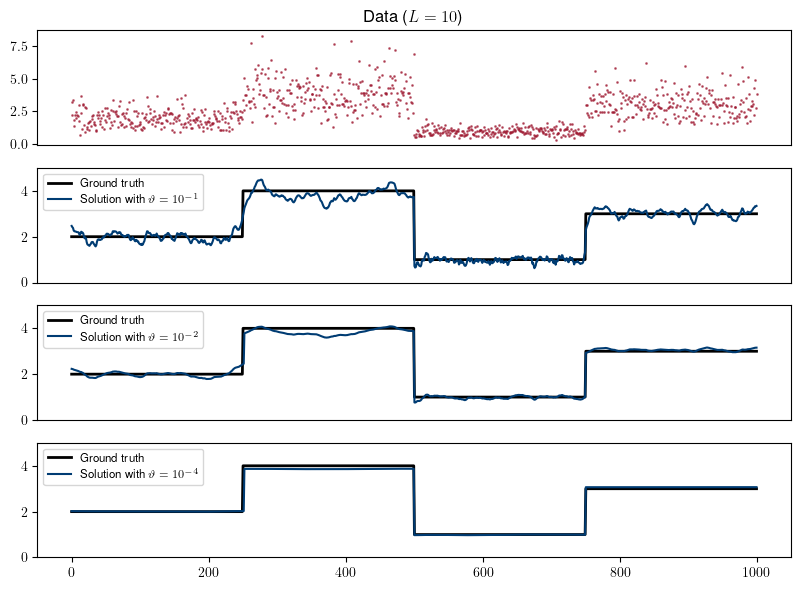

In [173]:
fig, axs = plt.subplots(4,1,figsize=(8,6))

axs[0].scatter([i for i in range(len(noisy_signal))], noisy_signal, label="Observation", s=1.0, alpha=0.6, color=dcolors["bonfire_red"])
axs[0].set_title("Data ($L = 10$)")

labels = [
    "Solution with $\\vartheta = 10^{-1}$",
    "Solution with $\\vartheta = 10^{-2}$", 
    "Solution with $\\vartheta = 10^{-4}$",  
]

for j, ax in enumerate(axs.reshape(-1)):

    if j < 1:
        ax.set_xticks([])
    else:
        ax.plot(ground_truth, label=r"Ground truth", color=dcolors["midnight_black"], lw=2.0)

        if j < 3:
            ax.set_xticks([])

        ax.plot(reconstructions[j-1], color=dcolors["river_navy"], label=labels[j-1])
        ax.set_ylim(0, 5)
        ax.legend(fontsize="small", loc="upper left")
        #ax.set_title(labels[j-1])
    
fig.tight_layout()

fig.savefig("log_varying_vartheta.png", dpi=250)

plt.show()

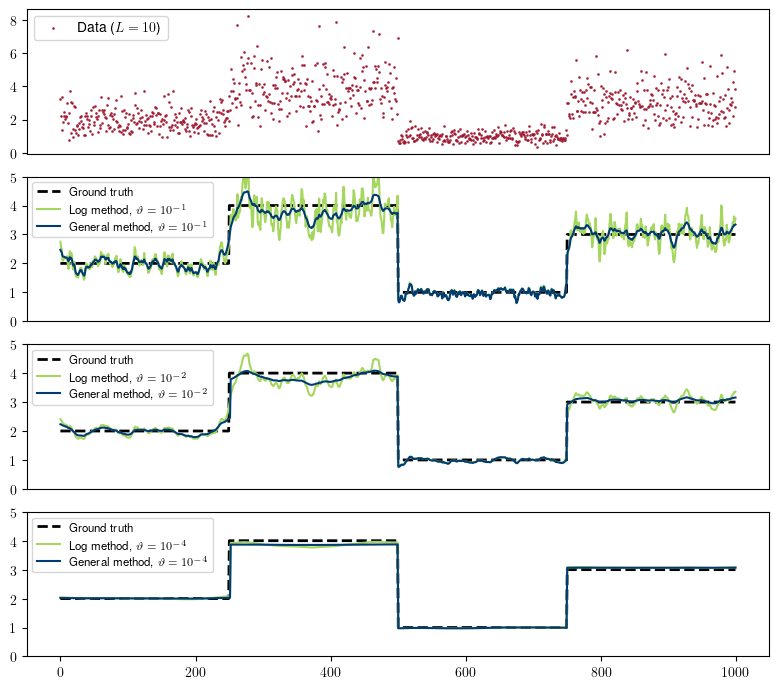

In [188]:
fig, axs = plt.subplots(4,1,figsize=(8,7))

axs[0].scatter([i for i in range(len(noisy_signal))], noisy_signal, label="Data ($L = 10$)", s=1.0, alpha=0.8, color=dcolors["bonfire_red"])
axs[0].legend(loc="upper left")


labels = [
    "General method, $\\vartheta = 10^{-1}$",
    "General method, $\\vartheta = 10^{-2}$", 
    "General method, $\\vartheta = 10^{-4}$",  
]

log_labels = [
    "Log method, $\\vartheta = 10^{-1}$",
    "Log method, $\\vartheta = 10^{-2}$", 
    "Log method, $\\vartheta = 10^{-4}$",  
]

for j, ax in enumerate(axs.reshape(-1)):

    if j < 1:
        ax.set_xticks([])
    else:
        ax.plot(ground_truth, label=r"Ground truth", color=dcolors["midnight_black"], lw=2.0, ls="--")

        if j < 3:
            ax.set_xticks([])

        ax.plot(log_reconstructions[j-1], color=dcolors["rich_spring_green"], label=log_labels[j-1])
        ax.plot(reconstructions[j-1], color=dcolors["river_navy"], label=labels[j-1])
        
        ax.set_ylim(0, 5)
        ax.legend(fontsize="small", loc="upper left")
        #ax.set_title(labels[j-1])
    
fig.tight_layout()

fig.savefig("both_varying_vartheta.png", dpi=250)

plt.show()